In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ROOT = '/content/drive'
HOME = ROOT + '/My Drive/public_transport'

In [3]:
cd '{HOME}'

/content/drive/My Drive/public_transport


In [4]:
#!conda install -c esri pyproj
!pip install pyproj

In [5]:
!pip install --upgrade tables                                                              # potrzebne do wczytania zawartości  plików hdf5 do colaba

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, json, csv, h5py, pickle, geopy.distance, os, math
from datetime import datetime
from time import sleep, strptime, mktime
from pyproj import Proj
from tqdm import tqdm
from numpy.linalg import norm

In [7]:
GPS_df = pd.read_hdf('GPS_df.h5', key='GPS_df', mode='r')
GPS_df.shape

(1136854, 20)

In [0]:
# GPS_df['speed'] = GPS_df[GPS_df['d_time'] > 0][ ['d_dist', 'd_time'] ]\
# .apply(lambda x: (x['d_dist'] * 1000 / x['d_time']), axis=1)

In [0]:
with open('stops_dist_dict.pickle', 'rb') as fp:
    stops_dist_dict = pickle.load(fp)

In [0]:
with open('schedule_dict.pickle', 'rb') as fp:
    schedule_dict = pickle.load(fp)

In [0]:
stops_df = pd.read_hdf('public_transport_warsaw.h5', key='stops_df_4', mode='r')

In [0]:
stop_coords = stops_df[stops_df.actual].set_index('id_nu')[['coord']].to_dict('dict')['coord']

Universal Transverse Mercator (UTM) is an international plane (rectangular) coordinate system. In the coordinate system, the world is divided into 60 zones of 6 degrees longitude. Each zone extends 3 degrees east and west from its central meridian and are numbered consecutively west to east from the 180-degree meridian. Transverse Mercator projections may then be applied to each zone.
https://www.gislounge.com/how-to-calculate-the-boundaries-of-an-utm-zone/

In [0]:
def utm_zone(longitude):
    assert -180 <= longitude < 180, "longitude range [-180, 180)"
    return int((longitude + 180.0) / 6) + 1

def utm_zone_boundary(nr):
    assert 1 <= nr <= 60, "utm zone range [1, 60]"
    east = nr*6.0 - 180
    west = east - 6
    return west, east

def xy_dist(a1, a2):
    assert (isinstance(a1, (list, tuple)) & isinstance(a2, (list, tuple))), "need two x,y coord arguments"
    assert ((len(a1)>1) & (len(a2)>1)), "need two x,y coord arguments"
    return math.sqrt((a1[0]-a2[0])**2 + (a1[1]-a2[1])**2)

In [13]:
print(utm_zone(21.0))
utm_zone_boundary(34)

34


(18.0, 24.0)

In [0]:
myProj = Proj("+proj=utm +zone=34 +north +ellps=WGS84 +datum=WGS84 +units=km +no_defs")
#myProj = Proj("+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6378137 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs")
#myProj = Proj(init='epsg:2180') #EPSG:2180, WGS 84 (EPSG:4326)

In [15]:
print(myProj(20.8988, 52.23857))
print(myProj(493.08955822011154, 5787.578011897543, inverse=True))

(493.08955822011154, 5787.578011897543)
(20.8988, 52.23857)


In [17]:
if type(list(stop_coords.values())[0]) == tuple:
    temp_dict = {}
    for key in tqdm(stop_coords.keys()):
        coord = stop_coords[key]
        coord_xy = myProj(coord[1], coord[0])
        new_element = [coord, (coord_xy[1], coord_xy[0])]
        temp_dict[key] = new_element
    stop_coords = temp_dict

100%|██████████| 7319/7319 [00:00<00:00, 8149.68it/s]


In [23]:
feat = ['Lines', 'Brigade', 'Time', 'coord', 'coord_xy', 'h_m_s', 'next_stop', 'dist_next', 'prev_stop', 'dist_prev']
df = GPS_df[GPS_df.Lines.isin(['122'])
      & GPS_df.Brigade.isin(['4'])][feat[3:10]].sort_values('h_m_s').reset_index()
df.iloc[29:35, 0:]

,index,coord,coord_xy,h_m_s,next_stop,dist_next,prev_stop,dist_prev
29,43787,"(52.238609000000004, 20.898773000000002)","(5787.582352338214, 493.08772058448596)",07:34:51,"(71, 5050_08, 07:36:00, 2)",0.00441,"(70, 5050_03, 07:21:00, 1)",0.12118
30,45192,"(52.238609000000004, 20.898777)","(5787.582351956719, 493.08799372416684)",07:35:11,"(71, 5050_08, 07:36:00, 2)",0.00430,"(70, 5050_03, 07:21:00, 1)",0.12136
31,51696,"(52.238602, 20.898789999999998)","(5787.581572125651, 493.0888803408292)",07:36:02,"(72, 5050_02, 07:37:00, 2)",0.22956,"(71, 5050_08, 07:36:00, 2)",0.00330
32,54289,"(52.239033, 20.898579)","(5787.6295312485445, 493.07453930685534)",07:36:24,"(72, 5050_02, 07:37:00, 2)",0.18266,"(71, 5050_08, 07:36:00, 2)",0.05337
33,55680,"(52.239204, 20.898611)","(5787.648548066278, 493.0767510118592)",07:36:35,"(72, 5050_02, 07:37:00, 2)",0.17003,"(71, 5050_08, 07:36:00, 2)",0.07139
34,57427,"(52.239208000000005, 20.898598)","(5787.648994217587, 493.0758639422669)",07:36:59,"(72, 5050_02, 07:37:00, 2)",0.16909,"(71, 5050_08, 07:36:00, 2)",0.07199


In [20]:
idx1 = 71
print(schedule_dict[('122', '4')][idx1])
coord = stop_coords[schedule_dict[('122', '4')][idx1][0]]
a1 = myProj(coord[0][1], coord[0][0])
print(a1)
print(coord[0][1], coord[0][0])

['5050_08', '07:36:00', 'Gwiaździsta', 'TP-GWI', 2, 6900.0, 29.92561]
(493.08955868605153, 5787.57834557953)
20.8988 52.238572999999995


In [21]:
idx2 = 72
print(schedule_dict[('122', '4')][idx2])
coord = stop_coords[schedule_dict[('122', '4')][idx2][0]]
a2 = myProj(coord[0][1], coord[0][0])
print(a2)
print(coord[0][1], coord[0][0])

['5050_02', '07:37:00', 'Gwiaździsta', 'TP-GWI', 2, 6960.0, 30.15821]
(492.9576995093898, 5787.769842878624)
20.896865 52.240293


In [24]:
idx = 5
coord =  df['coord'].iloc[idx]
a3 = myProj(coord[1], coord[0])
print(a3)
print(coord[1], coord[0])

(493.1006217824837, 5787.578997509113)
20.898962 52.238579


In [25]:
print(xy_dist(a1, a2))
schedule_dict[('122', '4')][idx2][6] - schedule_dict[('122', '4')][idx1][6]

0.2325038882048371


0.23260000000000147

In [26]:
['{}: [({:.6f}, {:.6f}), ({:.6f}, {:.6f})]'.format(one, 
                                         stop_coords[one][0][0], stop_coords[one][0][1],
                                         stop_coords[one][1][0], stop_coords[one][1][1])
 for one in stop_coords.keys()][0:10]

['1001_01: [(52.248455, 21.044827), (5788.673617, 503.060332)]',
 '1001_02: [(52.249078, 21.044443), (5788.742896, 503.034074)]',
 '1001_03: [(52.248998, 21.043983), (5788.733979, 503.002675)]',
 '1001_04: [(52.249905, 21.041726), (5788.834771, 502.848534)]',
 '1001_05: [(52.250319, 21.043861), (5788.880905, 502.994258)]',
 '1001_06: [(52.250008, 21.043710), (5788.846307, 502.983970)]',
 '1001_07: [(52.250228, 21.043690), (5788.870776, 502.982590)]',
 '1001_08: [(52.249944, 21.044087), (5788.839204, 503.009711)]',
 '1001_88: [(52.249944, 21.044087), (5788.839204, 503.009711)]',
 '1002_01: [(52.251325, 21.038457), (5788.992590, 502.625284)]']

In [0]:
# %%time
# GPS_df['coord_xy'] = GPS_df[ ['coord'] ].apply(lambda x: myProj(x['coord'][1], x['coord'][0])[::-1], axis=1)

Wall time: 27.7 s


In [0]:
# GPS_df.to_hdf('GPS_df.h5', key='GPS_df')

In [27]:
schedule_dict[('122', '4')][65:80]

[['5054_01', '07:13:00', 'os.Górczewska', 'TP-GOR', 1, 5520.0, 27.98305],
 ['5053_01', '07:14:00', 'os.Górczewska', 'TP-GOR', 1, 5580.0, 28.43972],
 ['5163_01', '07:16:00', 'os.Górczewska', 'TP-GOR', 1, 5700.0, 28.74575],
 ['5052_01', '07:18:00', 'os.Górczewska', 'TP-GOR', 1, 5820.0, 29.07103],
 ['5051_01', '07:19:00', 'os.Górczewska', 'TP-GOR', 1, 5880.0, 29.58059],
 ['5050_03', '07:21:00', 'os.Górczewska', 'TP-GOR', 1, 6000.0, 29.80023],
 ['5050_08', '07:36:00', 'Gwiaździsta', 'TP-GWI', 2, 6900.0, 29.92561],
 ['5050_02', '07:37:00', 'Gwiaździsta', 'TP-GWI', 2, 6960.0, 30.15821],
 ['5051_02', '07:39:00', 'Gwiaździsta', 'TP-GWI', 2, 7080.0, 30.43875],
 ['5052_02', '07:41:00', 'Gwiaździsta', 'TP-GWI', 2, 7200.0, 31.00649],
 ['5163_02', '07:42:00', 'Gwiaździsta', 'TP-GWI', 2, 7260.0, 31.22645],
 ['5053_02', '07:43:00', 'Gwiaździsta', 'TP-GWI', 2, 7320.0, 31.54559],
 ['5054_02', '07:44:00', 'Gwiaździsta', 'TP-GWI', 2, 7380.0, 31.93912],
 ['5055_07', '07:45:00', 'Gwiaździsta', 'TP-GWI', 2,

In [0]:
def draw_stops(b):         
    #b = stops_coords_list(line)
    print('stops nr: ', len(b))
    plt.figure(figsize=(10,6))
    plt.scatter(*zip(*b));
    
def flip(coords):
    return [(y, x) for x, y in coords]   # [x[::-1] for x in coords]

def find_next_idx(line, brigade, time):
    if (line, brigade) in schedule_dict:
        sched = schedule_dict[(line, brigade)]
    else: return None
    for idx, one in enumerate(sched, 0):
        if one[1] > time:
            return idx, one[0], one[1], one[4]
    return None

def find_prev_idx(line, brigade, next_idx):
    if next_idx <= 0: return None
    if (line, brigade) in schedule_dict:
        sched = schedule_dict[(line, brigade)]
        one = sched[next_idx-1]
        return next_idx-1, one[0], one[1], one[4]
    else: return None

def find_stops_by_schedule(line, brigade, time, past=12, future=0):
    sched = schedule_dict[(line, brigade)]
    stop_idx = find_stop_idx(line, brigade, time)[0]
    stops = [(x[0], x[4]) for x in sched[stop_idx-past : stop_idx+future+1]]
    return stops

def draw_stops_near(GPS_idx=31, sched_idx=0, past=12, future=0, coord=0, square=True):
    sched = schedule_dict[(line, brigade)]
    df = GPS_df[GPS_df.Lines.isin([line])
      & GPS_df.Brigade.isin([brigade])].sort_values('h_m_s').reset_index()
    if coord:
        GPS_coord = df.iloc[GPS_idx]['coord_xy']
    else:
        GPS_coord = df.iloc[GPS_idx]['coord']
    prev_coord = flip([stop_coords[x[0]][coord] for x in sched[sched_idx-past : sched_idx]])
    next_coord = flip([stop_coords[x[0]][coord] for x in sched[sched_idx+1 : sched_idx+future+1]])
    curr_coord = flip(stop_coords[sched[sched_idx][0]])[coord]
    GPS_time = df.iloc[GPS_idx]['h_m_s']
    next_by_sched = find_next_idx(line, brigade, GPS_time)
    prev_by_sched = find_prev_idx(line, brigade, next_by_sched[0])
    next_by_sched_coord = (stop_coords[sched[next_by_sched[0]][0]])[coord]
    print('GPS ', GPS_time, '     Prev ', prev_by_sched, '     Next ', next_by_sched)
    
    plt.figure(figsize=(10,6))
    if past:
        plt.scatter(*zip(*prev_coord), color='r', s=10)
    plt.scatter(curr_coord[0], curr_coord[1], color='y', marker='x')
    if future:
        plt.scatter(*zip(*next_coord), color='b', s=10)
    plt.scatter(GPS_coord[1], GPS_coord[0], color='r', marker='x')
    plt.scatter(next_by_sched_coord[1], next_by_sched_coord[0], color='g', marker='x', s=100)
    if square: 
        plt.axis('square')
    plt.show()

def dist_pl(p0, p1, p2): # p2 is the point
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    nom = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denom = ((y2 - y1)**2 + (x2 - x1) ** 2) ** 0.5
    result = nom / denom
    return result

def dist_pl_2(p0, p1, p2): # p2 is the point
    p0 = np.asarray([p0])
    p1 = np.asarray([p1])
    p2 = np.asarray([p2])
    return np.abs(np.cross(p1-p0, p2-p0)) / norm(p1-p0) # np.abs

def dist_pl_3(p0, p1, p2): # p2 is the point
    return pnt2line(pnt=(p2[0], p2[1], 0), start=(p0[0], p0[1], 0), end=(p1[0], p1[1], 0))[0]

def dist_ge(coord1, coord2): 
    return round(geopy.distance.distance(coord1, coord2).kilometers, 5)

In [0]:
import math

def dot(v,w):
    x,y,z = v
    X,Y,Z = w
    return x*X + y*Y + z*Z

def length(v):
    x,y,z = v
    return math.sqrt(x*x + y*y + z*z)

def vector(b,e):
    x,y,z = b
    X,Y,Z = e
    return (X-x, Y-y, Z-z)

def unit(v):
    x,y,z = v
    mag = length(v)
    return (x/mag, y/mag, z/mag)

def distance(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y,z = v
    return (x * sc, y * sc, z * sc)

def add(v,w):
    x,y,z = v
    X,Y,Z = w
    return (x+X, y+Y, z+Z)


# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest 
# distance from pnt to the line and the coordinates of the 
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line. 
# Malcolm Kesson 16 Dec 2012

def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)

In [30]:
print(pnt2line(pnt=(a3[0], a3[1], 0), start=(a1[0], a1[1], 0), end=(a2[0], a2[1], 0)))
print(pnt2line(pnt=(a3[0], a3[1], 0), start=(a2[0], a2[1], 0), end=(a1[0], a1[1], 0)))

(0.011082288339897191, (493.08955868605153, 5787.57834557953, 0.0))
(0.011082288339897191, (493.08955868605153, 5787.57834557953, 0.0))


In [0]:
a1 = a1[1], a1[0]
a2 = a2[1], a2[0]
a3 = a3[1], a3[0]
a1, a2, a3

((493.08955868605153, 5787.57834557953),
 (492.9576995093898, 5787.769842878624),
 (493.1006217824837, 5787.578997509113))

In [0]:
b1 = stop_coords[schedule_dict[('122', '4')][idx1][0]][0]
b2 = stop_coords[schedule_dict[('122', '4')][idx2][0]][0]
b3 = df['coord'].iloc[idx]

b1, b2, b3 = flip([b1, b2, b3])

(20.8988, 52.238572999999995) (20.896865, 52.240293) (20.898962, 52.238579)


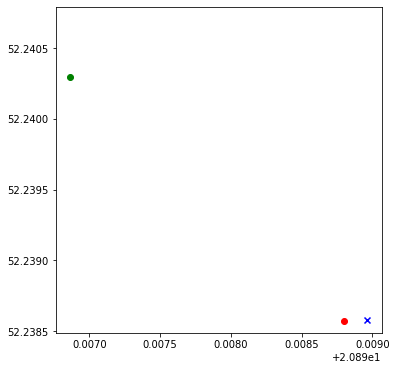

In [32]:
# b1 = myProj(a1[0], a1[1], inverse=True)
# b2 = myProj(a2[0], a2[1], inverse=True)
# b3 = myProj(a3[0], a3[1], inverse=True)
print(b1, b2, b3)
# print('reg1', dist_pl(b1, b2, b3))
# print('reg2', dist_pl_2(b1, b2, b3))
# print('rev1', dist_pl(b2, b1, b3))
# print('rev2', dist_pl_2(b2, b1, b3))
# print('reg 1_2', xy_dist(b1, b2), '1_3', xy_dist(b1, b3), '2_3', xy_dist(b2, b3))
# print('rev 1_2', xy_dist(b2, b1), '1_3', xy_dist(b3, b1), '2_3', xy_dist(b3, b2))
plt.figure(figsize=(10,6))
plt.scatter(b1[0], b1[1], color='r')
plt.scatter(b2[0], b2[1], color='g')
plt.scatter(b3[0], b3[1], color='b', marker='x')
plt.axis('square')
plt.show()

In [33]:
print('x_y 1_2', dist_ge(b1, b2), '1_3', dist_ge(b1, b3), '2_3', dist_ge(b2, b3))
print('rev 1_2', dist_ge(b2, b1), '1_3', dist_ge(b3, b1), '2_3', dist_ge(b3, b2))
print('geo 1_2', xy_dist(a1, a2), '1_3', xy_dist(a1, a3), '2_3', xy_dist(a2, a3))
print('rev 1_2', xy_dist(a2, a1), '1_3', xy_dist(a3, a1), '2_3', xy_dist(a3, a2))

x_y 1_2 0.27914 1_3 0.01795 2_3 0.29275
rev 1_2 0.27914 1_3 0.01795 2_3 0.29275
geo 1_2 0.2325038882048371 1_3 0.011082288339897191 2_3 0.2384297196455962
rev 1_2 0.2325038882048371 1_3 0.011082288339897191 2_3 0.2384297196455962


reg1 0.009245980074050664
reg2 [0.00948163]
reg3 0.011082288339897191
rev1 0.19892245208121273
rev2 [0.00948163]
rev3 0.011082288339897191
reg 1_2 0.2325038882048371 1_3 0.011082288339897191 2_3 0.2384297196455962
rev 1_2 0.2325038882048371 1_3 0.011082288339897191 2_3 0.2384297196455962


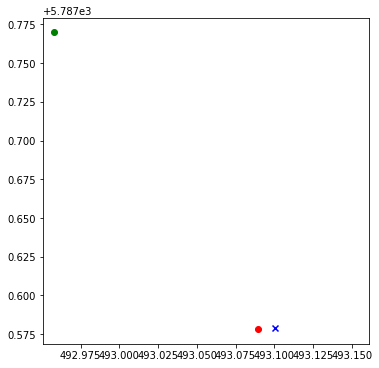

In [34]:
print('reg1', dist_pl(a1, a2, a3))
print('reg2', dist_pl_2(a1, a2, a3))
print('reg3', dist_pl_3(a1, a2, a3))
print('rev1', dist_pl(a2, a1, a3))
print('rev2', dist_pl_2(a2, a1, a3))
print('rev3', dist_pl_3(a2, a1, a3))
print('reg 1_2', xy_dist(a1, a2), '1_3', xy_dist(a1, a3), '2_3', xy_dist(a2, a3))
print('rev 1_2', xy_dist(a2, a1), '1_3', xy_dist(a3, a1), '2_3', xy_dist(a3, a2))
plt.figure(figsize=(10,6))
plt.scatter(a1[0], a1[1], color='r')
plt.scatter(a2[0], a2[1], color='g')
plt.scatter(a3[0], a3[1], color='b', marker='x')
plt.axis('square')
plt.show()

In [37]:
line, brigade = '122', '4'
@interact(GPS_idx=(0, 200), sched_idx=(0, 200), past=(0, 40), future=(0, 40), coord=(0, 1))
def draw_stops_near_slider(GPS_idx = 30, sched_idx=71, past=0, future=11, coord=0, square=True):
    draw_stops_near(GPS_idx, sched_idx, past, future, coord, square)

interactive(children=(IntSlider(value=30, description='GPS_idx', max=200), IntSlider(value=71, description='sc…

In [36]:
from ipywidgets import interact

@interact(gps_idx=(0, 100), sched_idx=(0, 100), prev=(0, 100), next=(0, 100))

def which_sector(gps_idx=30, sched_idx=70, prev=97, next=3):
    all_points = []
    x_ax = []
    row = df.iloc[gps_idx]
#     sched_idx = row['next_stop'][0]
    for x in range(sched_idx-prev, sched_idx+next):       
        sched0, sched1 = schedule_dict[('122', '4')][x], schedule_dict[('122', '4')][x+1]
        point2, point1, point0 = row['coord_xy'], stop_coords[sched1[0]][1], stop_coords[sched0[0]][1]
    #     print(sched0)
    #     print(sched1)
    #     print(point0, point1, point2)
        p0 = np.asarray([point0])
        p1 = np.asarray([point1])
        p2 = np.asarray([point2])
        all_points = np.append(all_points, dist_pl_2(p0, p1, p2))
        x_ax = np.append(x_ax, x).astype(int)

    print(x_ax[all_points.argmin()], row['h_m_s'], row['prev_stop'], int(row['dist_prev']*1000), \
          row['next_stop'], int(row['dist_next']*1000))

    # print(df.iloc[gps_idx:gps_idx+1, 3:])
    plt.xticks(range(len(x_ax)), x_ax)
    plt.plot(all_points)
    plt.show()

interactive(children=(IntSlider(value=30, description='gps_idx'), IntSlider(value=70, description='sched_idx')…

In [0]:
gps_idx = 4
row = df.iloc[gps_idx][['coord_xy', 'h_m_s', 'prev_stop', 'next_stop']]
print(row)
point3, point2, point1 = row['coord_xy'], stop_coords[row['next_stop'][1]][1], stop_coords[row['prev_stop'][1]][1]
print(point1, point2, point3)
p1 = np.asarray([point1])
p2 = np.asarray([point2])
p3 = np.asarray([point3])
np.abs(np.cross(p2-p1, p3-p1)) / norm(p2-p1)

coord_xy     (493.07453930685534, 5787.6295312485445)
h_m_s                                        07:36:24
prev_stop                  (71, 5050_08, 07:36:00, 2)
next_stop                  (72, 5050_02, 07:37:00, 2)
Name: 54289, dtype: object
(493.08955868605153, 5787.57834557953) (492.9576995093898, 5787.769842878624) (493.07453930685534, 5787.6295312485445)


array([0.01665834])

In [0]:
del idx

In [0]:
points = np.array([(0,10), (5,7), (1,1)])
points

array([[ 0, 10],
       [ 5,  7],
       [ 1,  1]])

In [0]:
p1 = np.asarray([(0,9)])
p2 = np.asarray([(5,7)])
p3 = np.asarray([(1,1)])

In [0]:
from numpy.linalg import norm
d = np.abs(np.cross(p2-p1, p1-p3)) / norm(p2-p1)
d

array([5.29150262, 4.78754999])

In [0]:
np.abs(np.cross(p2-p1, p3-p1)) / norm(p2-p1)

array([7.05642285])

In [0]:
np.cross(p2-p1,p3-p1)/norm(p2-p1)

array([-7.05642285])

In [0]:
abs(np.cross(p2-p1, p3-p1))/norm(p2-p1)

array([7.05642285])

In [0]:
%%time
for x in range(1000):
    np.abs(np.cross(p2-p1, p1-p3)) / norm(p2-p1)

Wall time: 40.9 ms


In [0]:
%%time
for x in range(1000):
    norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)

Wall time: 39.9 ms
